In [1]:
from base64 import standard_b64decode

import pandas as pd
import numpy as np

df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
df_model = df.copy()
df_model.shape


(7043, 21)

## 1.Data Preparation

BUbölümde modelleme öncesinde gerekli veri temizleme, encoding ve ölçekleme işlemleri yapılmıştır.

In [3]:
df_model =df_model.drop("customerID", axis=1)
df_model.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [4]:
# TotalCharges sayısallaştırıldı ve eksik değerler dolduruldu
df_model['TotalCharges'] = pd.to_numeric(
    df_model['TotalCharges'], errors='coerce'
)
df_model['TotalCharges'].isna().sum()

np.int64(11)

In [5]:
df_model['TotalCharges'] = df_model['TotalCharges'].fillna(
    df_model['TotalCharges'].median(),
)
df_model['TotalCharges'].head(10)

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
5     820.50
6    1949.40
7     301.90
8    3046.05
9    3487.95
Name: TotalCharges, dtype: float64

In [6]:
#churn 0/1 çevirme map ile

df_model["Churn"] = df_model["Churn"].map({"Yes": 1, "No": 0})
df_model["Churn"].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [7]:
df_model["Churn"].isna().sum()

np.int64(0)

In [8]:
cat_cols = df_model.select_dtypes(include="object").columns

In [9]:
#kategorik ve sayısal değişkenleri ayırma
cat_cols = df_model.select_dtypes(include="object").columns
num_cols = df_model.select_dtypes(include=["int64", "float64"]).columns
cat_cols, num_cols

(Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
        'PaperlessBilling', 'PaymentMethod'],
       dtype='object'),
 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object'))

In [10]:
#kategorik(string) için one-hot encoding
df_model_encoded = pd.get_dummies(
    df_model,
    columns=cat_cols,
    drop_first=True
)
df_model_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [11]:
X = df_model_encoded.drop("Churn", axis=1)
y = df_model_encoded["Churn"]
X.shape, y.shape

((7043, 30), (7043,))

In [12]:
#train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

In [13]:
#standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = ["tenure","MonthlyCharges","TotalCharges"]

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

## 2. Baseline Model - Logistic Regression

Bu bölümde müşteri churn tahmini için başlangıç (baseline) modeli olarak Logistic Regression kullanılmıştır.
Amaç, daha karmaşık modellerle karşılaştıralabilecek referans bir performans elde etmektir.

### 2.1 Model Training

In [14]:
#logistic regression
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    solver="liblinear",
    max_iter=1000
)
log_model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [15]:
y_pred = log_model.predict(X_test)
y_proba = log_model.predict_proba(X_test)[:,1]

### 2.2 Model Evaluation

In [16]:
#model performansı
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_proba))

Confusion Matrix:
[[925 110]
 [166 208]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.74      1409
weighted avg       0.80      0.80      0.80      1409


ROC AUC Score:
0.8423958252602753


### 2.3 ROC Curve

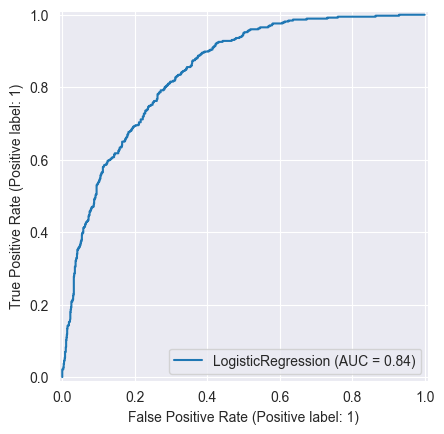

In [17]:
#roc curve

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(log_model, X_test, y_test)

### 2.4 Feature Importance

In [18]:
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": log_model.coef_[0]
}).sort_values(by="Coefficient",ascending=False)
coef_df.head(10)

,Feature,Coefficient
10,InternetService_Fiber optic,0.925667
3,TotalCharges,0.513780
28,PaymentMethod_Electronic check,0.375187
26,PaperlessBilling_Yes,0.367958
9,MultipleLines_Yes,0.309582
23,StreamingMovies_Yes,0.273416
21,StreamingTV_Yes,0.273302
0,SeniorCitizen,0.143841
29,PaymentMethod_Mailed check,0.063257
5,Partner_Yes,0.018826


**Değerlendirme:**
- Baseline Logistic Regression modeli ROC-AUC = 0.84 elde etmiştir.
- Churn (1) sınıfı için recall değeri %56 seviyesindedir.
- Bir sonraki adımda recall değerini artırmaya yönelik model iyileştirmeleri uygulanacaktır.


## 2.6 Threshold Tunning (Recall artırma)
Farklı eşikler denenerek churn (1) sınıfı için recall artırılması hedeflenmiştir.

In [20]:
threshold = 0.40
y_pred_thr = (y_proba >= threshold).astype(int)

from sklearn.metrics import confusion_matrix,classification_report

print("Threshold:", threshold)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_thr))

Threshold: 0.4
Confusion Matrix:
 [[848 187]
 [124 250]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.85      1035
           1       0.57      0.67      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.78      1409



**Seçilen Threshold:** 0.40
0.35 ve 0.40 eşik değerleri karşılaştırılmış, 0.40 daha dengeli precision–recall performansı sunduğu için tercih edilmiştir.
